# Project: King County Real Estate Price Analysis
## Complete Step-by-Step with Detailed Comments

## 1. Initial Setup and Library Import

In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 2. Data Loading and Initial Inspection

In [22]:
# Load the data
df = pd.read_csv('king_ country_ houses_aa.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (21613, 21)

First 5 rows:


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [23]:
# Basic dataset information
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("Basic Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float

## 3. Data Cleaning

In [24]:
# Check for missing values
print("Missing Values:")
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
missing_info = missing_info[missing_info['Missing Count'] > 0]
print(missing_info)

if missing_info.empty:
    print("No missing values found!")

Missing Values:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
No missing values found!


In [25]:
# Check for duplicates
print(f"Total duplicate rows: {df.duplicated().sum()}")
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print("Duplicates removed!")

Total duplicate rows: 0


In [26]:
# Data type verification and conversion
print("Data Types:")
print(df.dtypes)
print("\n" + "="*50)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')

# Check for any unusual values in categorical columns
categorical_cols = ['waterfront', 'view', 'condition', 'grade', 'zipcode']
for col in categorical_cols:
    print(f"\n{col} unique values: {sorted(df[col].unique())}")

Data Types:
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


waterfront unique values: [np.int64(0), np.int64(1)]

view unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

condition unique values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

grade unique values: [np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13)]

zipcode unique values: [np.int6

In [27]:
# Handle outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check outliers in numerical columns
numerical_cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

print("Outlier Analysis:")
for col in numerical_cols:
    outliers, lower, upper = detect_outliers_iqr(df, col)
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)")

Outlier Analysis:
price: 1146 outliers (5.30%)
bedrooms: 546 outliers (2.53%)
bathrooms: 571 outliers (2.64%)
sqft_living: 572 outliers (2.65%)
sqft_lot: 2425 outliers (11.22%)
sqft_above: 611 outliers (2.83%)
sqft_basement: 496 outliers (2.29%)
yr_built: 0 outliers (0.00%)
yr_renovated: 914 outliers (4.23%)


In [28]:
# Create cleaned dataset (optional: remove extreme outliers)
df_clean = df.copy()

# Remove extreme price outliers (top 1%)
price_threshold = df_clean['price'].quantile(0.99)
df_clean = df_clean[df_clean['price'] <= price_threshold]

print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_clean.shape}")

Original dataset shape: (21613, 21)
Cleaned dataset shape: (21396, 21)


## 4. Exploratory Data Analysis

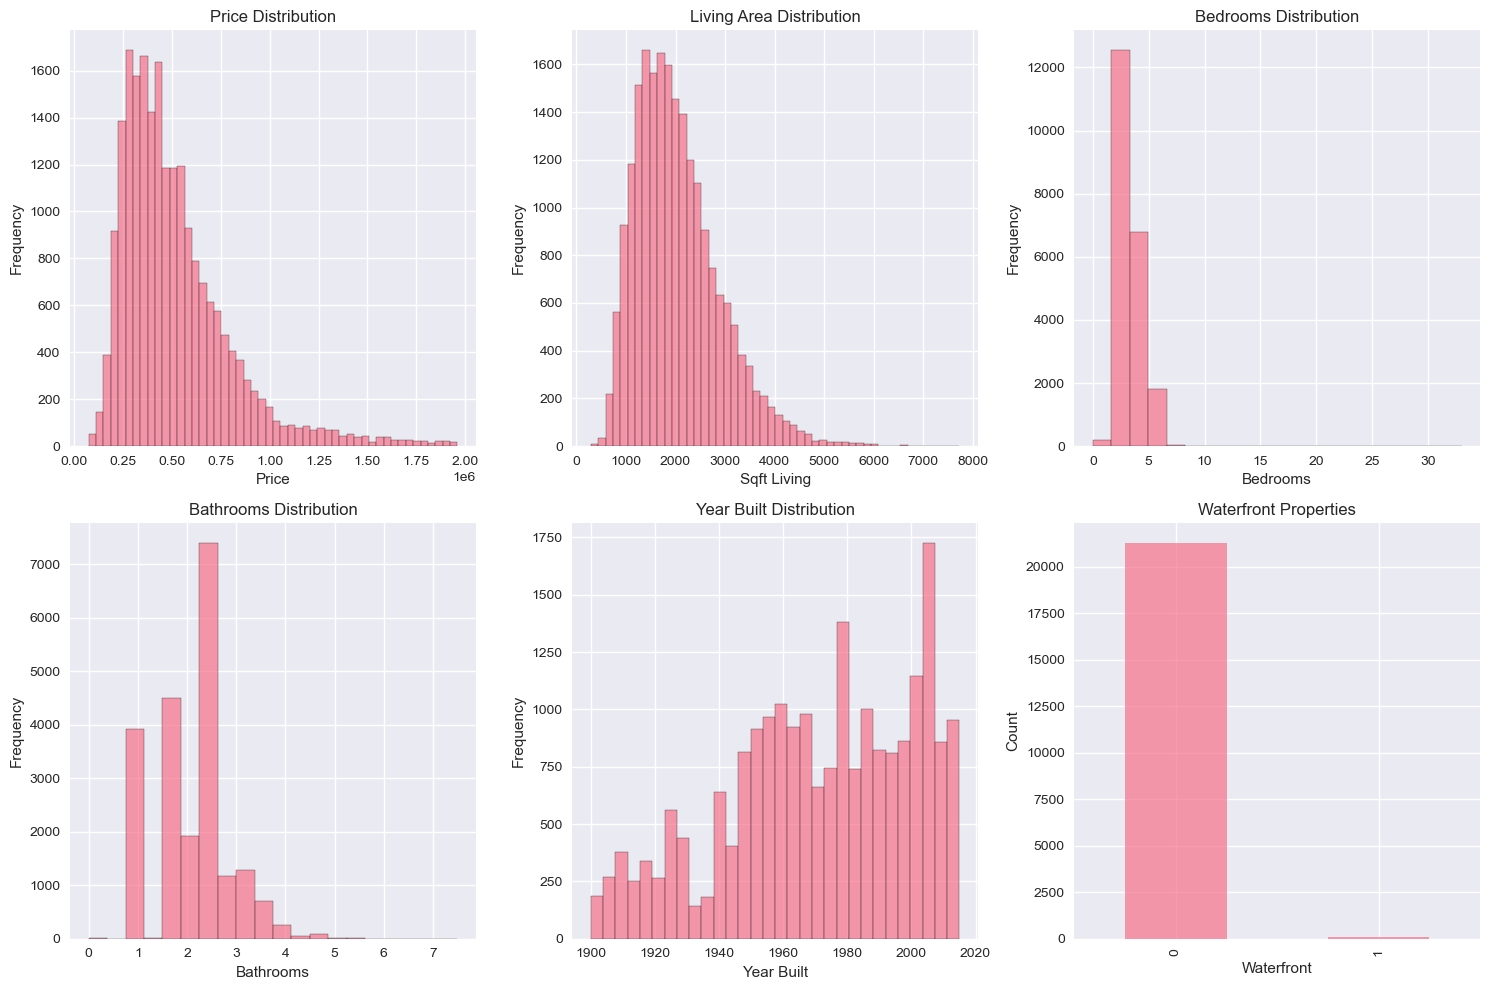

In [29]:
# Univariate Analysis

# Target variable distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df_clean['price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.hist(df_clean['sqft_living'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Living Area Distribution')
plt.xlabel('Sqft Living')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
plt.hist(df_clean['bedrooms'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Bedrooms Distribution')
plt.xlabel('Bedrooms')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
plt.hist(df_clean['bathrooms'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Bathrooms Distribution')
plt.xlabel('Bathrooms')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
plt.hist(df_clean['yr_built'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Year Built Distribution')
plt.xlabel('Year Built')
plt.ylabel('Frequency')

plt.subplot(2, 3, 6)
df_clean['waterfront'].value_counts().plot(kind='bar', alpha=0.7)
plt.title('Waterfront Properties')
plt.xlabel('Waterfront')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

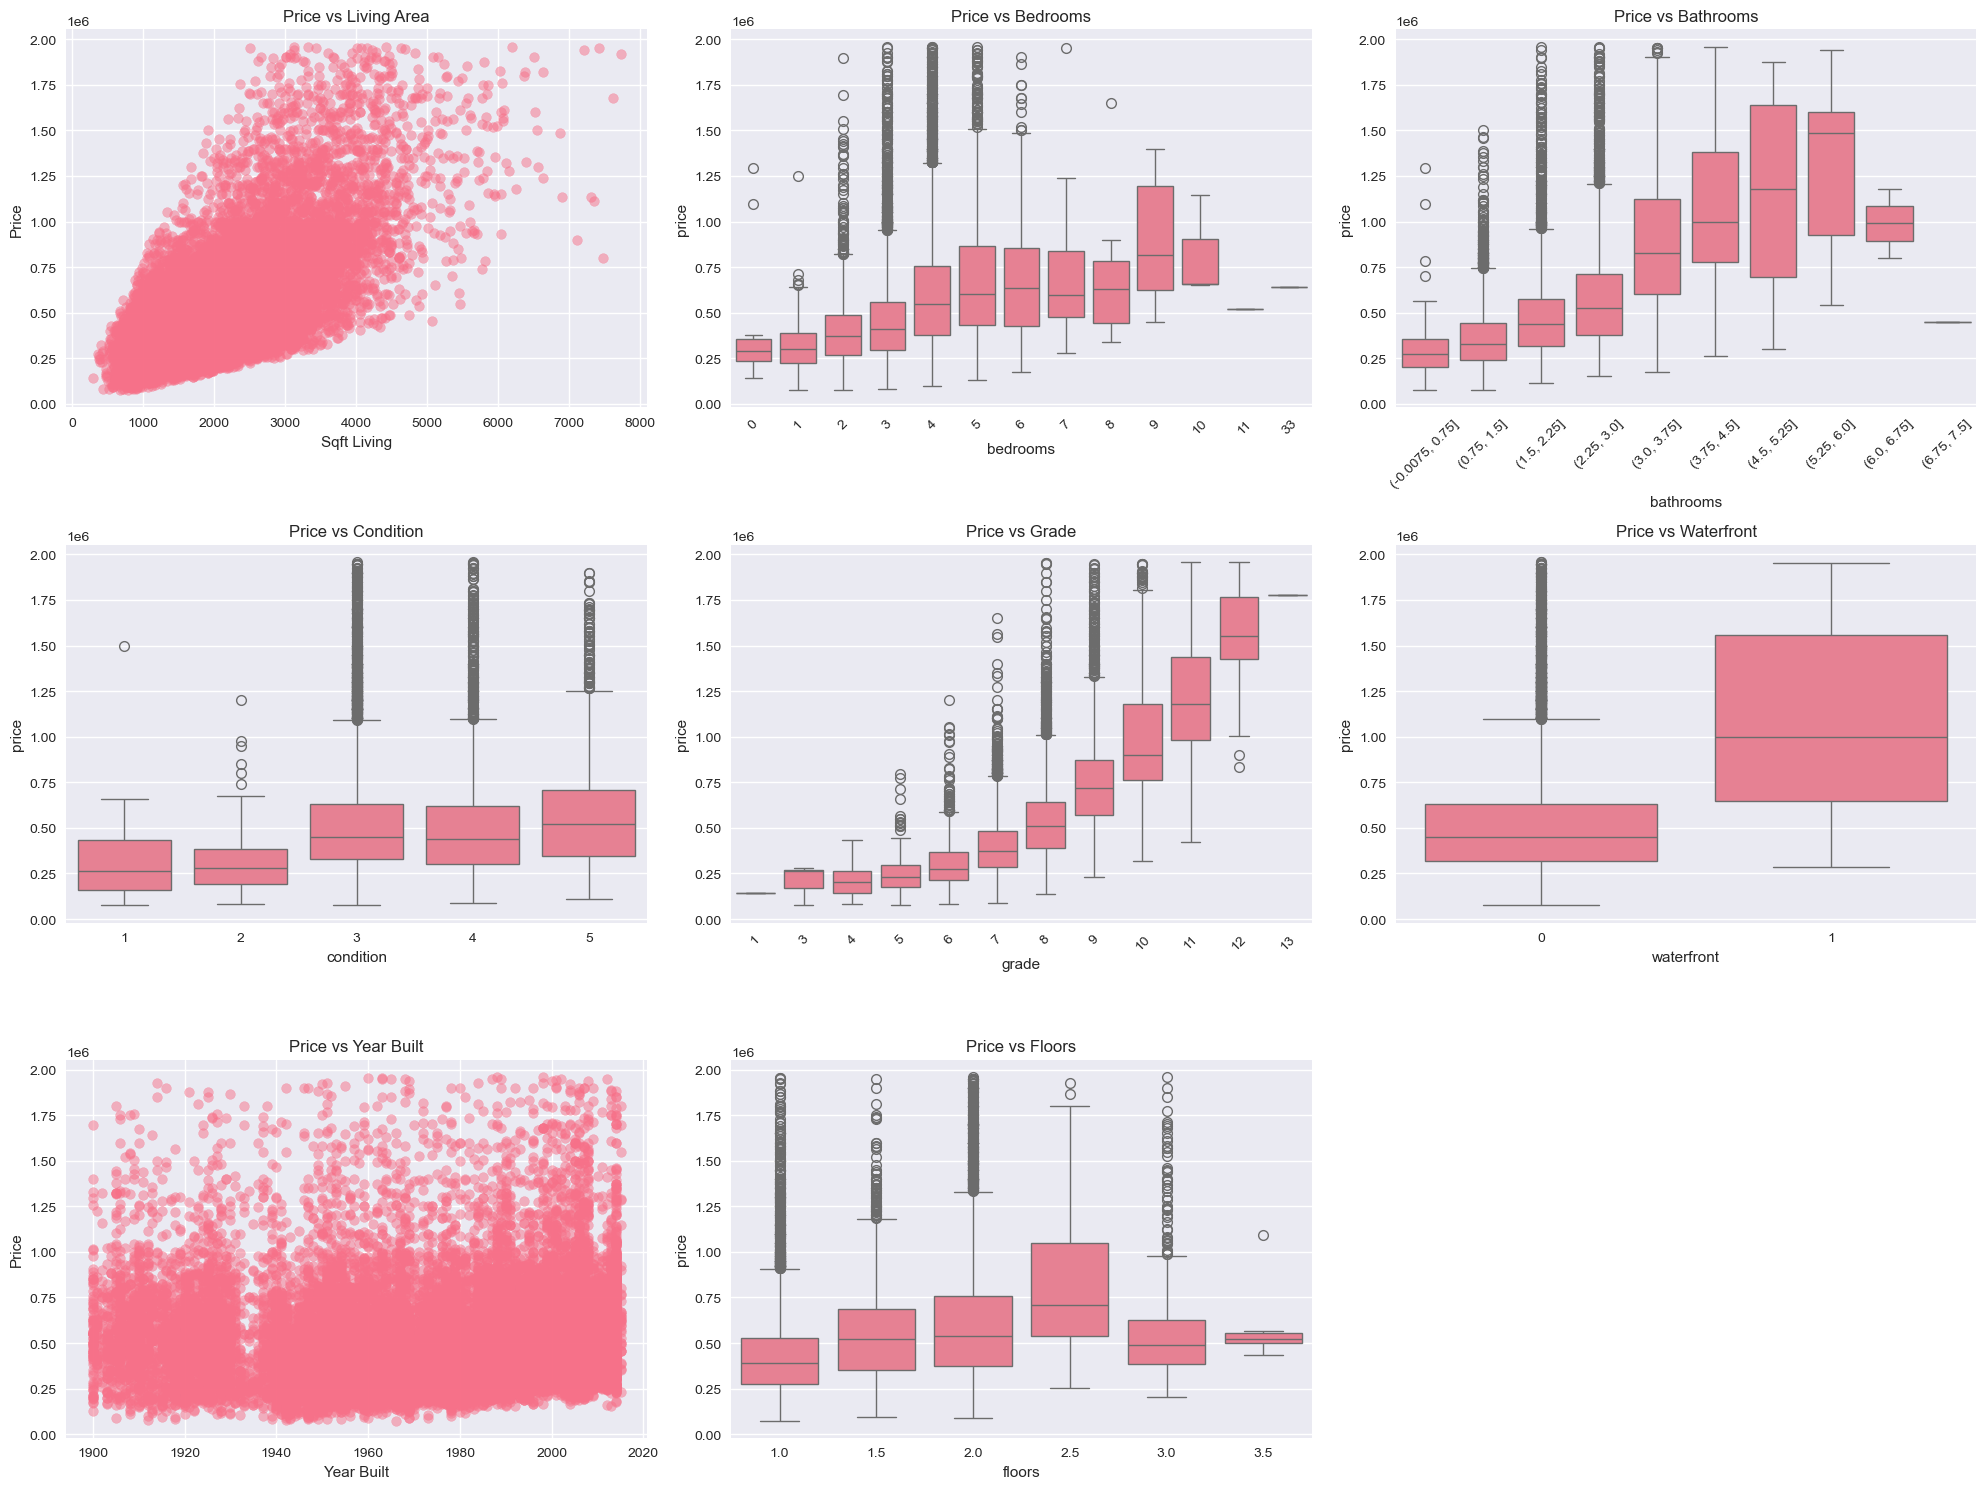

In [30]:
# Bivariate Analysis - Relationship with Price

plt.figure(figsize=(20, 15))

# Price vs Living Area
plt.subplot(3, 3, 1)
plt.scatter(df_clean['sqft_living'], df_clean['price'], alpha=0.5)
plt.title('Price vs Living Area')
plt.xlabel('Sqft Living')
plt.ylabel('Price')

# Price vs Bedrooms
plt.subplot(3, 3, 2)
sns.boxplot(x='bedrooms', y='price', data=df_clean)
plt.title('Price vs Bedrooms')
plt.xticks(rotation=45)

# Price vs Bathrooms
plt.subplot(3, 3, 3)
sns.boxplot(x=pd.cut(df_clean['bathrooms'], bins=10), y='price', data=df_clean)
plt.title('Price vs Bathrooms')
plt.xticks(rotation=45)

# Price vs Condition
plt.subplot(3, 3, 4)
sns.boxplot(x='condition', y='price', data=df_clean)
plt.title('Price vs Condition')

# Price vs Grade
plt.subplot(3, 3, 5)
sns.boxplot(x='grade', y='price', data=df_clean)
plt.title('Price vs Grade')
plt.xticks(rotation=45)

# Price vs Waterfront
plt.subplot(3, 3, 6)
sns.boxplot(x='waterfront', y='price', data=df_clean)
plt.title('Price vs Waterfront')

# Price vs Year Built
plt.subplot(3, 3, 7)
plt.scatter(df_clean['yr_built'], df_clean['price'], alpha=0.5)
plt.title('Price vs Year Built')
plt.xlabel('Year Built')
plt.ylabel('Price')

# Price vs Floors
plt.subplot(3, 3, 8)
sns.boxplot(x='floors', y='price', data=df_clean)
plt.title('Price vs Floors')

plt.tight_layout()
plt.show()

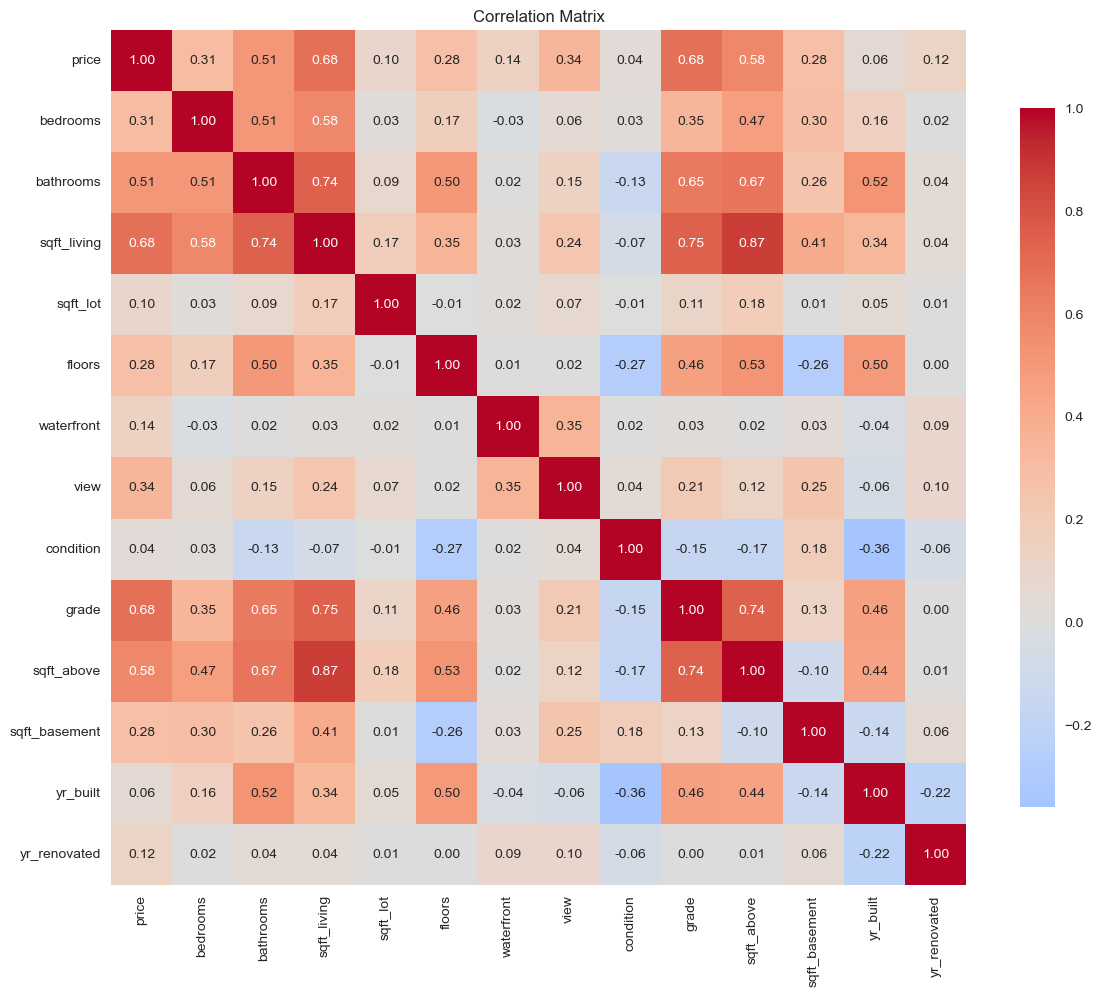

Top correlations with Price:
price            1.000000
grade            0.680255
sqft_living      0.678890
sqft_above       0.584035
bathrooms        0.506781
view             0.343619
bedrooms         0.314876
sqft_basement    0.284578
floors           0.279157
waterfront       0.143603
yr_renovated     0.119850
sqft_lot         0.098376
yr_built         0.063479
condition        0.036670
Name: price, dtype: float64


In [31]:
# Correlation Analysis

# Select numerical columns for correlation
numerical_for_corr = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                     'floors', 'waterfront', 'view', 'condition', 'grade', 
                     'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

correlation_matrix = df_clean[numerical_for_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Top correlations with price
price_correlations = correlation_matrix['price'].sort_values(ascending=False)
print("Top correlations with Price:")
print(price_correlations)

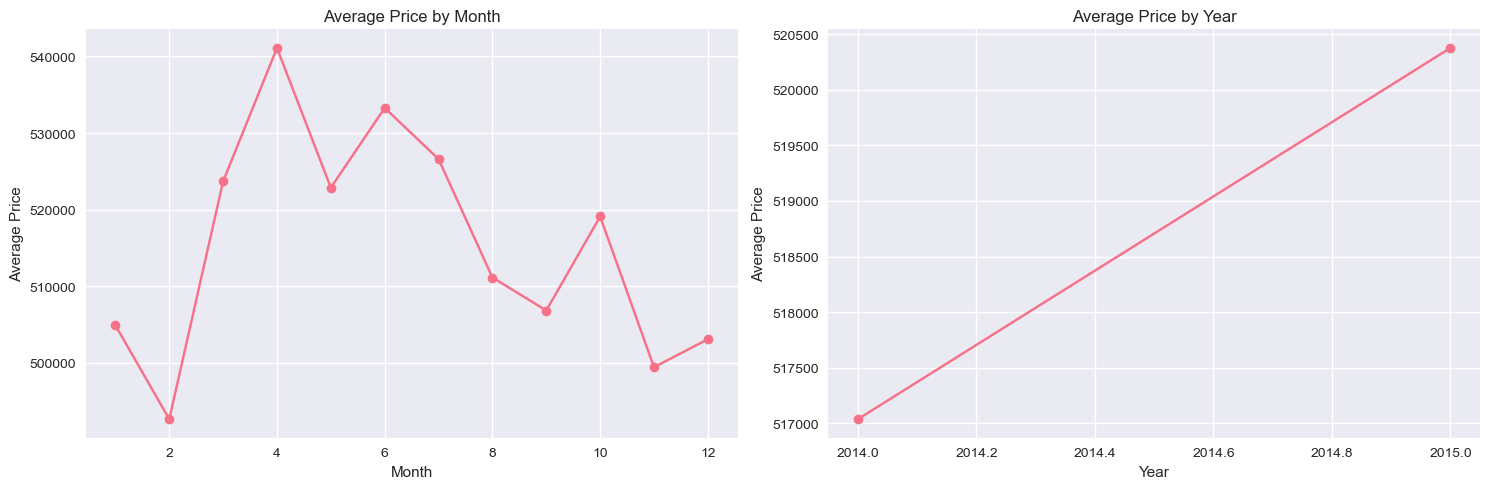

In [32]:
# Time Series Analysis

# Extract year and month from date
df_clean['sale_year'] = df_clean['date'].dt.year
df_clean['sale_month'] = df_clean['date'].dt.month

# Price trends over time
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
monthly_avg_price = df_clean.groupby('sale_month')['price'].mean()
monthly_avg_price.plot(kind='line', marker='o')
plt.title('Average Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.grid(True)

plt.subplot(1, 2, 2)
yearly_avg_price = df_clean.groupby('sale_year')['price'].mean()
yearly_avg_price.plot(kind='line', marker='o')
plt.title('Average Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.grid(True)

plt.tight_layout()
plt.show()

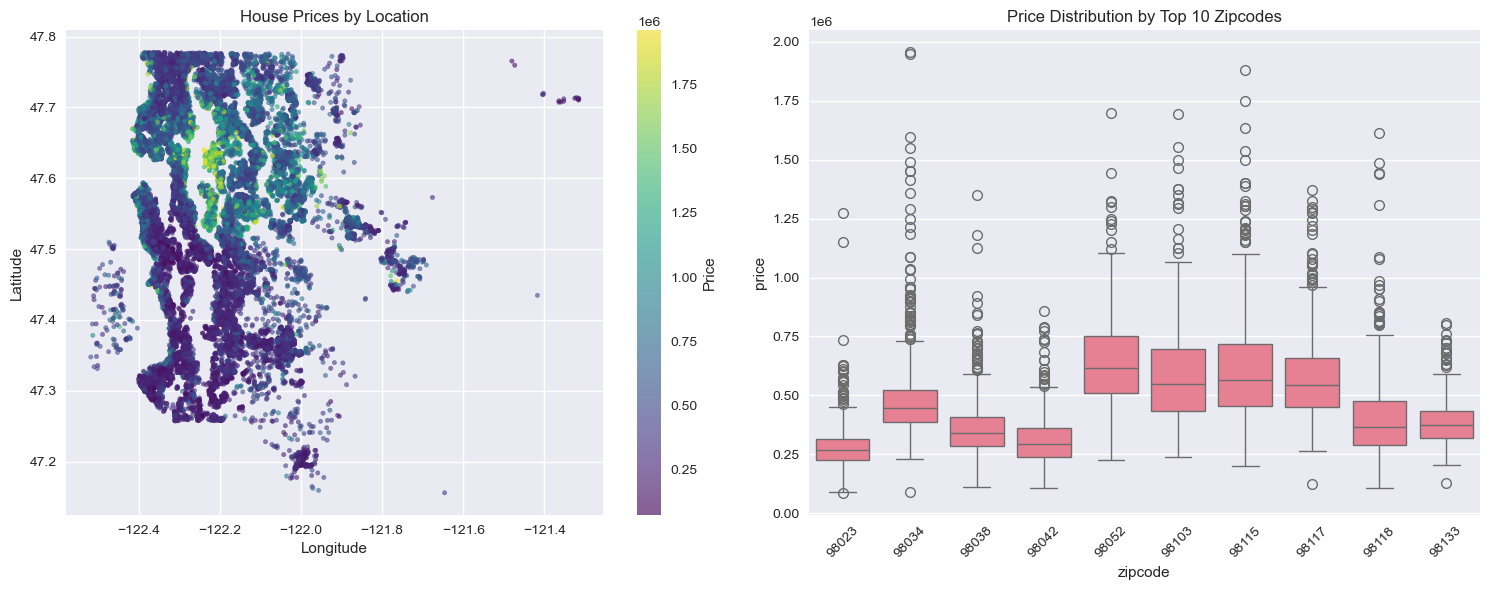

In [33]:
# Geographical Analysis

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_clean['long'], df_clean['lat'], 
           c=df_clean['price'], cmap='viridis', 
           alpha=0.6, s=10)
plt.colorbar(label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('House Prices by Location')

plt.subplot(1, 2, 2)
# Price distribution by zipcode (top 10)
top_zipcodes = df_clean['zipcode'].value_counts().head(10).index
df_top_zip = df_clean[df_clean['zipcode'].isin(top_zipcodes)]
sns.boxplot(x='zipcode', y='price', data=df_top_zip)
plt.title('Price Distribution by Top 10 Zipcodes')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 5. Feature Engineering Insights

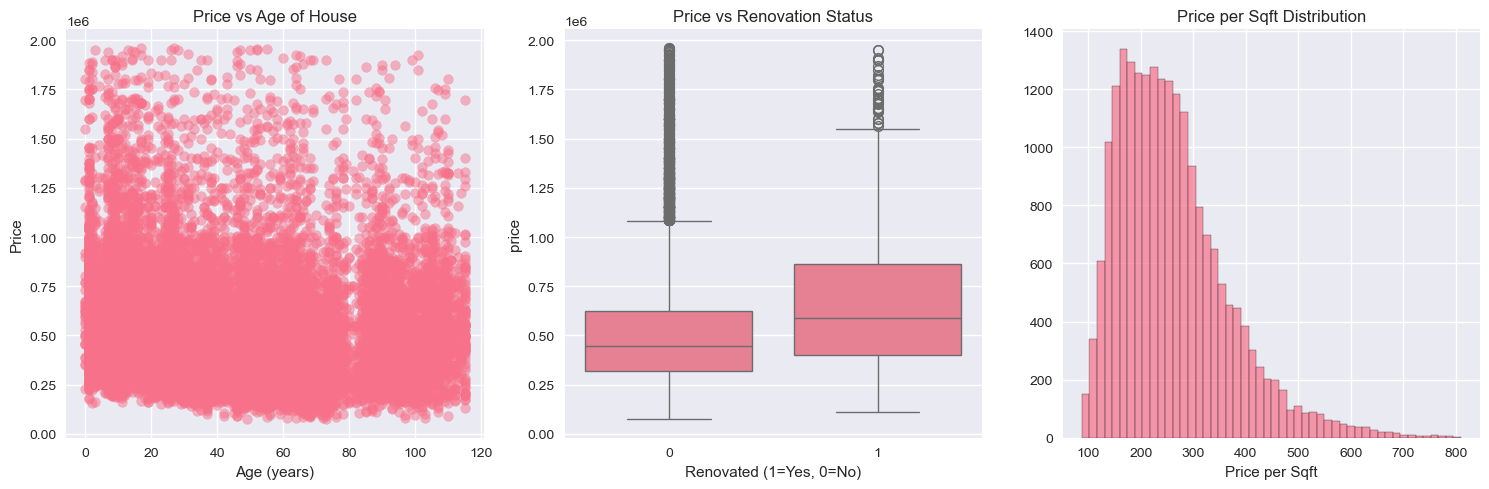

In [34]:
# Create some derived features
df_clean['age'] = 2015 - df_clean['yr_built']  # Assuming 2015 as reference year
df_clean['is_renovated'] = (df_clean['yr_renovated'] > 0).astype(int)
df_clean['price_per_sqft'] = df_clean['price'] / df_clean['sqft_living']

# Analyze new features
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(df_clean['age'], df_clean['price'], alpha=0.5)
plt.title('Price vs Age of House')
plt.xlabel('Age (years)')
plt.ylabel('Price')

plt.subplot(1, 3, 2)
sns.boxplot(x='is_renovated', y='price', data=df_clean)
plt.title('Price vs Renovation Status')
plt.xlabel('Renovated (1=Yes, 0=No)')

plt.subplot(1, 3, 3)
plt.hist(df_clean['price_per_sqft'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Price per Sqft Distribution')
plt.xlabel('Price per Sqft')

plt.tight_layout()
plt.show()

In [35]:
# Summary Statistics and Key Findings

print("="*50)
print("KEY FINDINGS SUMMARY")
print("="*50)

print(f"1. Dataset Size: {df_clean.shape[0]} houses, {df_clean.shape[1]} features")
print(f"2. Price Range: ${df_clean['price'].min():,} - ${df_clean['price'].max():,}")
print(f"3. Average Price: ${df_clean['price'].mean():,.2f}")
print(f"4. Average Living Area: {df_clean['sqft_living'].mean():.0f} sqft")
print(f"5. Most Common Bedrooms: {df_clean['bedrooms'].mode()[0]}")
print(f"6. Correlation with Price:")
print(f"   - Sqft Living: {correlation_matrix.loc['sqft_living', 'price']:.3f}")
print(f"   - Grade: {correlation_matrix.loc['grade', 'price']:.3f}")
print(f"   - Bathrooms: {correlation_matrix.loc['bathrooms', 'price']:.3f}")

# Waterfront properties analysis
waterfront_stats = df_clean.groupby('waterfront')['price'].agg(['mean', 'count'])
print(f"7. Waterfront Properties: {waterfront_stats.loc[1, 'count']} houses")
print(f"   - Avg Price (Waterfront): ${waterfront_stats.loc[1, 'mean']:,.0f}")
print(f"   - Avg Price (Non-Waterfront): ${waterfront_stats.loc[0, 'mean']:,.0f}")

# Renovation analysis
reno_stats = df_clean.groupby('is_renovated')['price'].mean()
print(f"8. Renovated Houses: {df_clean['is_renovated'].sum()} houses")
print(f"   - Avg Price (Renovated): ${reno_stats[1]:,.0f}")
print(f"   - Avg Price (Not Renovated): ${reno_stats[0]:,.0f}")

KEY FINDINGS SUMMARY
1. Dataset Size: 21396 houses, 26 features
2. Price Range: $75,000.0 - $1,960,000.0
3. Average Price: $518,115.33
4. Average Living Area: 2050 sqft
5. Most Common Bedrooms: 3
6. Correlation with Price:
   - Sqft Living: 0.679
   - Grade: 0.680
   - Bathrooms: 0.507
7. Waterfront Properties: 114 houses
   - Avg Price (Waterfront): $1,076,488
   - Avg Price (Non-Waterfront): $515,124
8. Renovated Houses: 882 houses
   - Avg Price (Renovated): $682,050
   - Avg Price (Not Renovated): $511,067


In [36]:
# Step 16: Save cleaned dataset
df_clean.to_csv('king_country_houses_cleaned.csv', index=False)
print("Cleaned dataset saved as 'king_country_houses_cleaned.csv'")

Cleaned dataset saved as 'king_country_houses_cleaned.csv'
